In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import io

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow_addons as tfa

import tensorflow.keras as keras

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


root_logdir = os.path.join(os.curdir, "logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


def get_data():
    fashion_mnist = keras.datasets.fashion_mnist
    (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
    X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    X_test = X_test / 255.
    
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    y_valid = keras.utils.to_categorical(y_valid, num_classes=10)
    y_test = keras.utils.to_categorical(y_test, num_classes=10)
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)


def build_model():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="elu", kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="elu", kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation="softmax")
    ])
    
    metrics = [
        "categorical_accuracy",
        "categorical_crossentropy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tfa.metrics.F1Score(num_classes=10,average="macro", name='f1_score')
    ]

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=metrics)
    
    return model


def sparse_categorical_confusion_matrix(X_test, y_test, model):
    y_pred=model.predict_classes(X_test)
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.jet)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return con_mat_df



def categorical_confusion_matrix(X_test, y_test, model):
    y_test = np.argmax(y_test, axis=1)
    return sparse_categorical_confusion_matrix(X_test, y_test, model)


def _log_sparse_categorical_confusion_matrix_func(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred = model.predict_classes(X_test)

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=test_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, annot=True,cmap=mpl.cm.jet)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
        

def _log_categorical_confusion_matrix_func(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred = model.predict_classes(X_test)

    con_mat = tf.math.confusion_matrix(labels=cat_y_test, predictions=test_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, annot=True,cmap=mpl.cm.jet)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)        


def sparse_categorical_confusion_matrix_callback():
    return keras.callbacks.LambdaCallback(on_epoch_end=_log_sparse_categorical_confusion_matrix_func)


def categorical_confusion_matrix_callback():
    return keras.callbacks.LambdaCallback(on_epoch_end=_log_categorical_confusion_matrix_func)


def get_classes(nparr):
    classes = pd.DataFrame(np.argmax(y_test,axis=1))[0].unique()
    classes.sort()
    return classes

In [3]:
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_03_22-17_32_11'

In [4]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = get_data()

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

saved_model_name = "my_keras_model.h5"

model = build_model()
cat_y_test = np.argmax(y_test, axis=1)
file_writer = tf.summary.create_file_writer(run_logdir + '\\cm')
classes = get_classes(y_test)

callbacks = [
    keras.callbacks.ModelCheckpoint(saved_model_name, save_best_only=True, save_weights_only=True),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir, profile_batch = 100000000),
    categorical_confusion_matrix_callback()
]

history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

model.load_weights(saved_model_name) # rollback to best model

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 13s 239us/sample - loss: 0.4870 - categorical_accuracy: 0.8246 - categorical_crossentropy: 0.4870 - precision: 0.8698 - recall: 0.7763 - fn: 12302.0000 - fp: 6393.0000 - tn: 488607.0000 - tp: 42698.0000 - f1_score: 0.8234 - val_loss: 0.3714 - val_categorical_accuracy: 0.8674 - val_categorical_crossentropy: 0.3714 - val_precision: 0.9046 - val_recall: 0.8346 - val_fn: 827.0000 - val_fp: 440.0000 - val_tn: 44560.0000 - val_tp: 4173.0000 - val_f1_score: 0.8646
Epoch 2/5
55000/55000 [==============================] - 11s 206us/sample - loss: 0.3642 - categorical_accuracy: 0.8666 - categorical_crossentropy: 0.3642 - precision: 0.8948 - recall: 0.8403 - fn: 8784.0000 - fp: 5435.0000 - tn: 489565.0000 - tp: 46216.0000 - f1_score: 0.8663 - val_loss: 0.3419 - val_categorical_accuracy: 0.8760 - val_categorical_crossentropy: 0.3419 - val_precision: 0.9042 - val_recall: 0.8528 - val_fn: 736.00

In [6]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

Reusing TensorBoard on port 6006 (pid 7680), started 3:45:52 ago. (Use '!kill 7680' to kill it.)

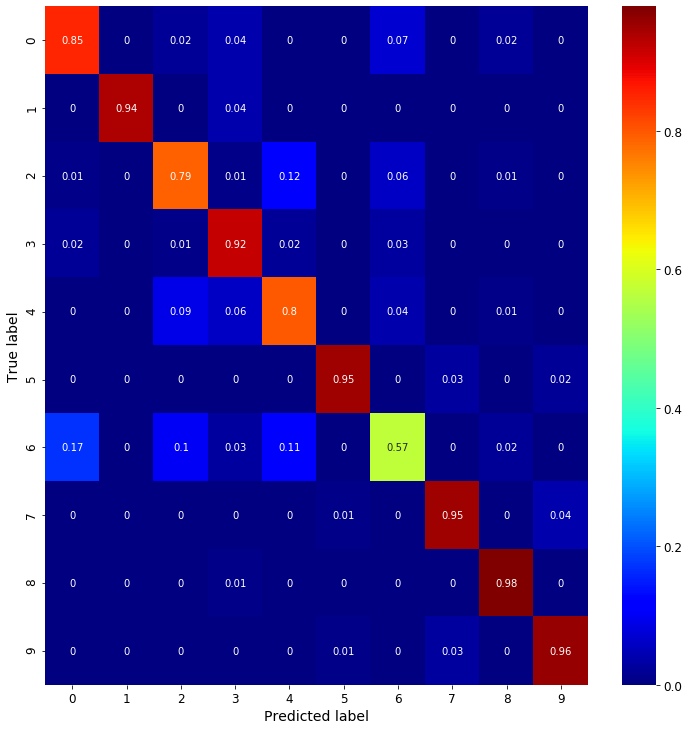

,0,1,2,3,4,5,6,7,8,9
0,0.85,0.00,0.02,0.04,0.00,0.00,0.07,0.00,0.02,0.00
1,0.00,0.94,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00
2,0.01,0.00,0.79,0.01,0.12,0.00,0.06,0.00,0.01,0.00
3,0.02,0.00,0.01,0.92,0.02,0.00,0.03,0.00,0.00,0.00
4,0.00,0.00,0.09,0.06,0.80,0.00,0.04,0.00,0.01,0.00
5,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.03,0.00,0.02
6,0.17,0.00,0.10,0.03,0.11,0.00,0.57,0.00,0.02,0.00
7,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.95,0.00,0.04
8,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.98,0.00
9,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.96


In [7]:
categorical_confusion_matrix(X_test, y_test, model)

In [8]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 155us/sample - loss: 0.3581 - categorical_accuracy: 0.8717 - categorical_crossentropy: 0.3581 - precision: 0.8948 - recall: 0.8557 - fn: 1443.0000 - fp: 1006.0000 - tn: 88994.0000 - tp: 8557.0000 - f1_score: 0.8697


[0.3580577667236328,
 0.8717,
 0.35805765,
 0.89480287,
 0.8557,
 1443.0,
 1006.0,
 88994.0,
 8557.0,
 0.8696517]

Saving figure keras_learning_curves_plot


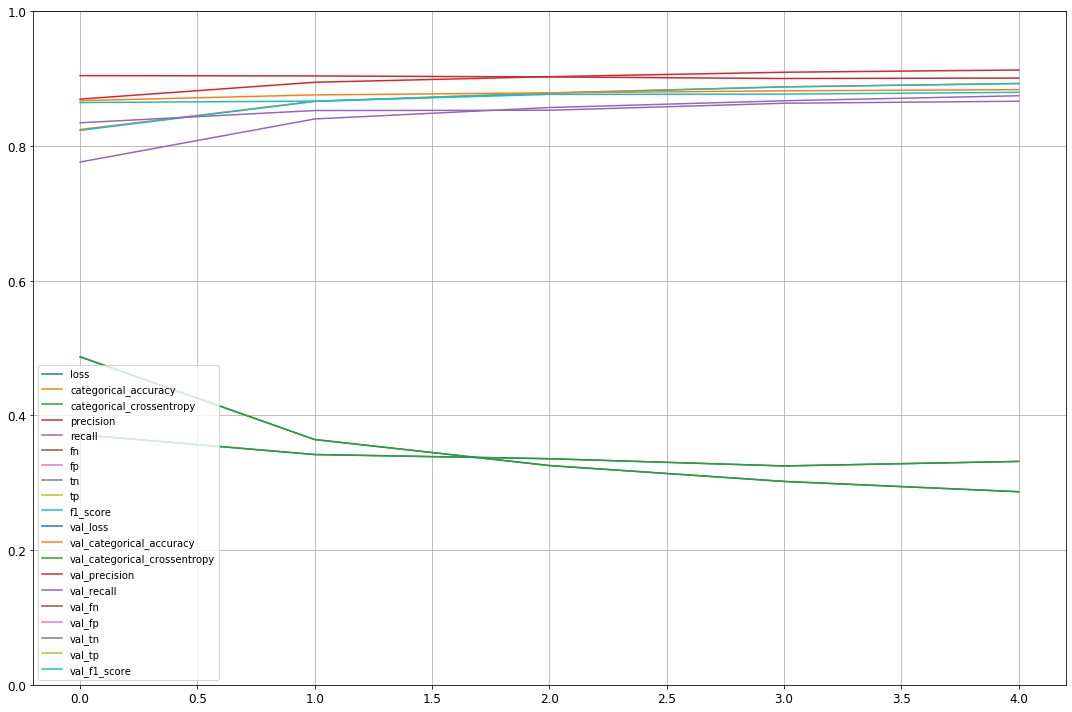

In [9]:
def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(15, 10))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    save_fig("keras_learning_curves_plot")
    plt.show()

plot_history(history)